# haMSM Analysis Tutorial

This tutorial will demonstrate haMSM analysis on WE data using the `msm_we` package. We will analyze data from an NTL9 simulation, run with the restarting plugin.

In [1]:
from msm_we import msm_we

In [2]:
import mdtraj as md
import numpy as np

## Initialization

In [3]:
base_path = 'restart0'
file_paths = [
    f'{base_path}/run{run+1}/west.h5' for run in range(5)
]

ref_structure = 'ref_files/reference.pdb'

Prior to model building, ensure that your `west.h5` has been augmented with the full atomic coordinates in `auxdata/coord`. 
This is done for you when running WESTPA with the haMSM plugin. However, if you have WESTPA data that was generated without the plugin, you can still augment the `west.h5` file to work with the haMSM analysis.

For an example of how to do this, please see [the `prepare_coordinates()` function of the haMSM plugin](https://github.com/jdrusso/westpa/blob/restarting_plugin/src/westpa/westext/hamsm_restarting/restart_driver.py#L100).

## Manual model-building

The above process is super convenient, but if you want to develop and fine-tune your pipeline, or debug specific steps, it can be helpful to manually run through the model building steps instead.

In [4]:
from msm_we import msm_we
import matplotlib.pyplot as plt
import ray

#### Define feature selection

Before we can start building our model, we must write a `processCoordinates()` function. This takes in the full set of atomic coordinates from `west.h5:/iteration_xxxx/auxdata/coord` and returns the set of coordinates which will be used to build the model. This is useful for selecting out an important or representative subset of the full atoms, since the full set of atoms is likely not necessary for analysis, adds noise, and lengthens runtime.

**It's necessary to define your own `processCoordinates()` rather than having one provided by the analysis library because this choice of selection is extremely system dependent.**

**<u>DO NOT</u>** copy this processCoordinates around and expect it to work with any arbitrary system!

Then, *after* importing `msm_we`, monkey-patch it with your new `processCoordinates()`.

In [5]:
def processCoordinates(self, coords):

    if self.dimReduceMethod == "none":
        nC = np.shape(coords)
        nC = nC[0]
        data = coords.reshape(nC, 3 * self.nAtoms)
        return data

    elif self.dimReduceMethod == "pca":

        # Dimensionality reduction 

        xt = md.Trajectory(xyz=coords, topology=None)
        indCA = self.reference_structure.topology.select("name CA")
        pair1, pair2 = np.meshgrid(indCA, indCA, indexing="xy")
        indUT = np.where(np.triu(pair1, k=1) > 0)
        pairs = np.transpose(np.array([pair1[indUT], pair2[indUT]])).astype(int)
        dist = md.compute_distances(xt, pairs, periodic=True, opt=True)
        
        return dist
    
msm_we.modelWE.processCoordinates = processCoordinates

#### Initialize model

First, let's launch Ray so we can parallelize some slow parts of the calculation. Feel free to change `num_cpus` to however many available cores you have on your machine.

For advanced users, instead of intializing a new cluster here you can launch a Ray cluster externally, and connect the `msm_we` analysis to it here.

In [6]:
ray.init(num_cpus=2, ignore_reinit_error=True)

2021-12-07 16:32:16,145	INFO services.py:1263 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '192.168.1.200',
 'raylet_ip_address': '192.168.1.200',
 'redis_address': '192.168.1.200:24571',
 'object_store_address': '/tmp/ray/session_2021-12-07_16-32-12_913210_68962/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-12-07_16-32-12_913210_68962/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2021-12-07_16-32-12_913210_68962',
 'metrics_export_port': 60848,
 'node_id': 'aef1bd60c34c7c298190c5d95717822561ca7695da3297440fe6fcd6'}

Now, let's initialize the haMSM model.

In [7]:
model = msm_we.modelWE()

In [8]:
model.initialize(
    file_paths,
    ref_structure,
    modelName='NTL9',
    basis_pcoord_bounds = [[9.6, np.inf]],
    target_pcoord_bounds = [[-np.inf, 1.0]],
    dim_reduce_method = 'pca',
    tau = 1,
    pcoord_ndim=1,
)

#### Load coordinates into model

The cells below will read our data files, and update the model with some information about your WESTPA run.

We load our coordinates with `streaming=True` so we can process large datasets frame-by-frame, without storing them all in memory at once. Disabling this provides a small performance boost, at the cost of potentially substantial memory usage.

In [9]:
model.get_iterations()

model.get_coordSet(last_iter=model.maxIter, streaming=True)

Getting coordSet:   0%|          | 0/100 [00:00<?, ?it/s]

#### Dimensionality reduction

Next, we perform some dimensionality reduction on our model to reduce the number of features we're looking at.

When doing discretization in the next step, dimensionality reduction is done by passing coordinates into a transformer object. This step builds the appropriate transformer object. In this example, it calculates a PCA model for the data.

(Note that the data is not actually transformed in this step -- this builds the model, and prepares the transformer, which is applied in the next step.)

In [10]:
model.dimReduce()

Initial iPCA:   0%|          | 0/50 [00:00<?, ?it/s]

/Users/russojd/opt/anaconda3/envs/westpa_openmm/lib/python3.9/site-packages/sklearn/decomposition/_incremental_pca.py:316: RuntimeWarning: Mean of empty slice.
  explained_variance[self.n_components_:].mean()
/Users/russojd/opt/anaconda3/envs/westpa_openmm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


iPCA:   0%|          | 0/99 [00:00<?, ?it/s]

#### Clustering

Now, we can determine our discretization by clustering.

Note that the number of cluster centers is very important, and can drastically affect the quality of your model. It is generally a good idea to attempt a range of values.

Also note that `n_clusters` is the number of clusters *per WE bin* under stratified clustering (or the total number of clusters if stratified clustering is disabled). You should not disable stratified clustering unless you really, really have a good reason and know what you're doing.

This performs "stratified" k-means clustering with 10 cluster centers in each WE bin, using streaming, with Ray for parallelism, and building the k-means model with iterations 20 and on to exclude some initial burn-in.

In [11]:
model.cluster_coordinates(n_clusters=10, first_cluster_iter=20, 
                          streaming=True, use_ray=True, stratified=True)

[12/07/21 16:33:14] INFO     Be aware: Number of cluster centers is an         ]8;id=1638923594.2316759-710589;file:///Users/russojd/Research/molssi_2021/msmWE_cc/msm_we/msm_we/msm_we.py\msm_we.py]8;;\:2940
                             important parameter, and can drastically affect                 
                             model quality. We recommend examining                           
                             block-validation results with a range of numbers                
                             of clusters, to check for overfitting.

                    INFO     Beginning stratified clustering.                  ]8;id=1638923594.240128-5147;file:///Users/russojd/Research/molssi_2021/msmWE_cc/msm_we/msm_we/msm_we.py\msm_we.py]8;;\:2947

                    INFO     Obtaining bin definitions from iteration 2 in     ]8;id=1638923594.2456698-883202;file:///Users/russojd/Research/molssi_2021/msmWE_cc/msm_we/msm_we/msm_we.py\msm_we.py]8;;\:3364
                             file restart0/run1/west.h5

                    INFO     Loading pickled bin mapper from H5 for stratified ]8;id=1638923594.257813-995526;file:///Users/russojd/Research/molssi_2021/msmWE_cc/msm_we/msm_we/msm_we.py\msm_we.py]8;;\:3368
                             clustering...

                    INFO     Doing stratified clustering with 530 total         ]8;id=1638923594.2682638-358570;file:///Users/russojd/Research/molssi_2021/msmWE_cc/msm_we/msm_we/msm_we.py\msm_we.py]8;;\:250
                             clusters

Clustering:   0%|          | 0/80 [00:00<?, ?it/s]

[12/07/21 16:33:28] INFO     Using Ray cluster with 2.0 CPUs!                   ]8;id=1638923608.485909-276863;file:///Users/russojd/Research/molssi_2021/msmWE_cc/msm_we/msm_we/msm_we.py\msm_we.py]8;;\:869

Submitting discretization tasks:   0%|          | 0/99 [00:00<?, ?it/s]

Retrieving discretized trajectories:   0%|          | 0/99 [00:00<?, ?it/s]

[12/07/21 16:33:38] INFO     Discretization complete                           ]8;id=1638923618.840731-39702;file:///Users/russojd/Research/molssi_2021/msmWE_cc/msm_we/msm_we/msm_we.py\msm_we.py]8;;\:3993

#### Flux matrix calculation + cleaning

Now we can build a flux matrix, using the discretization from our clustering.

In [12]:
model.get_fluxMatrix(0, first_iter=1, last_iter=model.maxIter, use_ray=True)

                    INFO     Using Ray cluster with 2.0 CPUs!                   ]8;id=1638923618.8739939-818337;file:///Users/russojd/Research/molssi_2021/msmWE_cc/msm_we/msm_we/msm_we.py\msm_we.py]8;;\:869

Submitting fluxmatrix tasks:   0%|          | 0/99 [00:00<?, ?it/s]

Retrieving flux matrices:   0%|          | 0/99 [00:00<?, ?it/s]

[12/07/21 16:33:55] INFO     Fluxmatrices all obtained                         ]8;id=1638923635.0781171-813792;file:///Users/russojd/Research/molssi_2021/msmWE_cc/msm_we/msm_we/msm_we.py\msm_we.py]8;;\:4624

The flux matrix computed in the previous step may have clusters that do not connect to the target state, typically just as a result of finite sampling. For example, "sinks"  where all trajectories that entered a cluster happened to be pruned (or the WE run ended before they transitioned out). 

When computing steady-state fluxes, if these are not removed, probability will accumulate in these and get trapped, unable to reach the target state and recycle. This will cause errors in computing both probability distributions and fluxes, so these states must be "cleaned" by removing them and reassigning structures in them to a "good" cluster.

In the cleaning, we identify the largest set of connected states, remove all the other states, and rediscretize on those.

After computing the set of "good" states, cleaning requires rediscretizing the data and recalculating the flux matrix using the new clusters, so we again use Ray to parallelize that.

In [13]:
model.organize_fluxMatrix(use_ray=True)

                    INFO     Started with 530 clusters, and removed 304        ]8;id=1638923635.1174378-249287;file:///Users/russojd/Research/molssi_2021/msmWE_cc/msm_we/msm_we/msm_we.py\msm_we.py]8;;\:3840

                    WARNING  All clusters were cleaned from bins {0, 52}       ]8;id=1638923635.1199958-949664;file:///Users/russojd/Research/molssi_2021/msmWE_cc/msm_we/msm_we/msm_we.py\msm_we.py]8;;\:3856

                    INFO     Using Ray cluster with 2.0 CPUs!                   ]8;id=1638923635.124557-450853;file:///Users/russojd/Research/molssi_2021/msmWE_cc/msm_we/msm_we/msm_we.py\msm_we.py]8;;\:869

Submitting discretization tasks:   0%|          | 0/99 [00:00<?, ?it/s]

Retrieving discretized trajectories:   0%|          | 0/99 [00:00<?, ?it/s]

[12/07/21 16:34:05] INFO     Discretization complete                           ]8;id=1638923645.434585-927338;file:///Users/russojd/Research/molssi_2021/msmWE_cc/msm_we/msm_we/msm_we.py\msm_we.py]8;;\:3993

/Users/russojd/Research/molssi_2021/msmWE_cc/msm_we/msm_we/msm_we.py:4064: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.targetRMSD_all = np.array(cluster_pcoord_all)[pcoord_sort_indices]


                    INFO     Using Ray cluster with 2.0 CPUs!                   ]8;id=1638923645.661057-595166;file:///Users/russojd/Research/molssi_2021/msmWE_cc/msm_we/msm_we/msm_we.py\msm_we.py]8;;\:869

Submitting fluxmatrix tasks:   0%|          | 0/99 [00:00<?, ?it/s]

Retrieving flux matrices:   0%|          | 0/99 [00:00<?, ?it/s]

[12/07/21 16:34:21] INFO     Fluxmatrices all obtained                         ]8;id=1638923661.9019651-408439;file:///Users/russojd/Research/molssi_2021/msmWE_cc/msm_we/msm_we/msm_we.py\msm_we.py]8;;\:4624

Finally, we can compute the transition matrix by row-normalizing the flux matrix, and add in our steady-state boundary conditions by adding a direct transition from sink to source.

This transition matrix is available as the attribute `model.Tmatrix`.

In [14]:
model.get_Tmatrix()

## Model analysis

Now that we have built the haMSM, let's analyze some features from it.

First, let's compute steady-state from the transition matrix, and use that to estimate the target flux. This number is in units of 1/tau.

In [15]:
model.get_steady_state()
model.get_steady_state_target_flux()

print(f"Steady-state target flux is {model.JtargetSS:.2e}")

[12/07/21 16:34:22] INFO                                                       ]8;id=1638923662.101333-436079;file:///Users/russojd/Research/molssi_2021/msmWE_cc/msm_we/msm_we/msm_we.py\msm_we.py]8;;\:5267
                             Flux converged to 2.6317e-10 after 1 iterations                 
                             of inverse iteration.

                    INFO     Done with steady-state estimation.                ]8;id=1638923662.1038961-876252;file:///Users/russojd/Research/molssi_2021/msmWE_cc/msm_we/msm_we/msm_we.py\msm_we.py]8;;\:5278

Steady-state target flux is 2.63e-10


It's also important to look at flux profiles to analyze convergence. When in steady-state, flux profiles should be flat.

First, let's look at the flux profile along a progress coordinate.

                    CRITICAL No cross-validation models have been generated!   ]8;id=1638923662.113973-450614;file:///Users/russojd/Research/molssi_2021/msmWE_cc/msm_we/msm_we/msm_we.py\msm_we.py]8;;\:5859
                             Do this before making plots.

                    WARNING  Fluxes have not yet been generated for            ]8;id=1638923662.150501-897900;file:///Users/russojd/Research/molssi_2021/msmWE_cc/msm_we/msm_we/msm_we.py\msm_we.py]8;;\:5902
                             main_model, generating now.

<AxesSubplot:xlabel='Pcoord 0', ylabel='Flux (weight/second'>

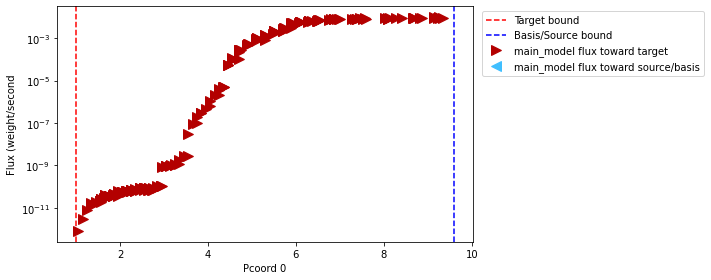

In [16]:
model.plot_flux(suppress_validation=True)

Although that's useful, plotting against progress coordinate may be misleading, since the transition region may not be evenly distributed in progress coordinate space.

To see if that's the case, let's look at the committor vs progress coordinate for our clusters.

The committor is 1 at the target state, and 0 at the source. So by looking at this plot, and seeing where the committor starts to break away from 0, we can get an idea of where the transition region is.

If you had a "perfect" progress coordinate, this would be a diagonal line.

[12/07/21 16:34:24] WARNING  Note that, if steady-state weighted ensemble data ]8;id=1638923664.009921-949467;file:///Users/russojd/Research/molssi_2021/msmWE_cc/msm_we/msm_we/msm_we.py\msm_we.py]8;;\:6687
                             is being analyzed, this is a 'pseudocommittor'                  
                             and not a true committor as a result of being                   
                             constructed from a one-way ensemble.

  0%|          | 0/5.0 [00:00<?, ?it/s]

                    WARNING  Note that, if steady-state weighted ensemble data ]8;id=1638923664.182632-48594;file:///Users/russojd/Research/molssi_2021/msmWE_cc/msm_we/msm_we/msm_we.py\msm_we.py]8;;\:6687
                             is being analyzed, this is a 'pseudocommittor'                  
                             and not a true committor as a result of being                   
                             constructed from a one-way ensemble.

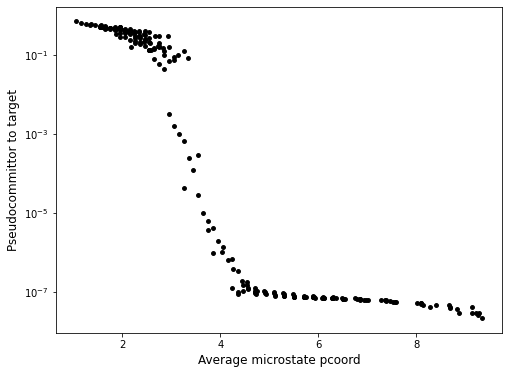

In [17]:
model.get_committor()
model.plot_committor()

Now that we've seen that the progress coordinate and the committor describe our space differently, let's look at a flux profile plotted against the committor.

[12/07/21 16:34:25] CRITICAL No cross-validation models have been generated!   ]8;id=1638923665.7324958-340304;file:///Users/russojd/Research/molssi_2021/msmWE_cc/msm_we/msm_we/msm_we.py\msm_we.py]8;;\:5724
                             Do this before making plots.

                    WARNING  Committor-fluxes have not yet been generated for  ]8;id=1638923665.7663958-275619;file:///Users/russojd/Research/molssi_2021/msmWE_cc/msm_we/msm_we/msm_we.py\msm_we.py]8;;\:5756
                             main_model, generating now.

Obtaining pseudocommittor-fluxes:   0%|          | 0/227 [00:00<?, ?it/s]

[12/07/21 16:34:27] WARNING  Note that, if steady-state weighted ensemble data ]8;id=1638923667.4078982-151389;file:///Users/russojd/Research/molssi_2021/msmWE_cc/msm_we/msm_we/msm_we.py\msm_we.py]8;;\:6687
                             is being analyzed, this is a 'pseudocommittor'                  
                             and not a true committor as a result of being                   
                             constructed from a one-way ensemble.

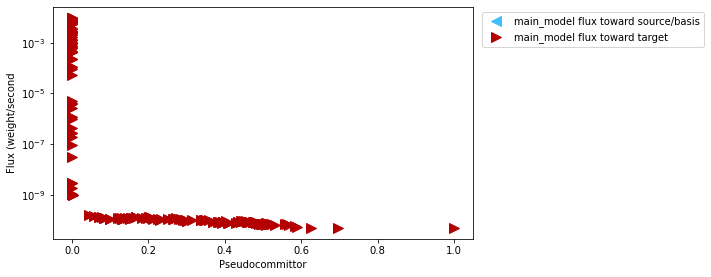

In [18]:
model.plot_flux_committor(suppress_validation=True)
plt.gca().set_xscale('linear')

This likely looks much flatter, which tells us that the flux is level in the transition region, an important metric for convergence.

## Simple automatic model-building

Now, the easy way.

`msm_we` provides the `modelWE.build_analyze_model()` function, which will execute all the necessary steps to load your data, construct an MSM, and cross-validate the result.

This is convenient, although for more detailed debugging, it can be useful to run the individual steps one by one as described above.

In [19]:
from msm_we import msm_we
import numpy as np
import mdtraj as md

In [20]:
def processCoordinates(self, coords):

    if self.dimReduceMethod == "none":
        nC = np.shape(coords)
        nC = nC[0]
        data = coords.reshape(nC, 3 * self.nAtoms)
        return data

    elif self.dimReduceMethod == "pca":

        # Dimensionality reduction 

        xt = md.Trajectory(xyz=coords, topology=None)
        indCA = self.reference_structure.topology.select("name CA")
        pair1, pair2 = np.meshgrid(indCA, indCA, indexing="xy")
        indUT = np.where(np.triu(pair1, k=1) > 0)
        pairs = np.transpose(np.array([pair1[indUT], pair2[indUT]])).astype(int)
        dist = md.compute_distances(xt, pairs, periodic=True, opt=True)
        
        return dist
    
msm_we.modelWE.processCoordinates = processCoordinates

In [21]:
model = msm_we.modelWE()

model.build_analyze_model(
    ray_kwargs = {'num_cpus': 4, 'include_dashboard': False},
    file_paths = file_paths,
    ref_struct = ref_structure,
    modelName  = 'NTL9',
    basis_pcoord_bounds = [[9.6, np.inf]],
    target_pcoord_bounds = [[-np.inf, 1.0]],
    dimreduce_method = 'pca',
    tau = 1,
    n_clusters = 2,
    # Optional arguments below
    max_coord_iter=-1,
    stratified=True,
    streaming=True,
    use_ray=True,
    fluxmatrix_iters=[1,-1],
    fluxmatrix_iters_to_use=None,
    show_live_display=True
)

Output()

Getting coordSet:   0%|          | 0/100 [00:00<?, ?it/s]

/Users/russojd/opt/anaconda3/envs/westpa_openmm/lib/python3.9/site-packages/sklearn/decomposition/_incremental_pca.py:316: RuntimeWarning: Mean of empty slice.
  explained_variance[self.n_components_:].mean()
/Users/russojd/opt/anaconda3/envs/westpa_openmm/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


iPCA:   0%|          | 0/99 [00:00<?, ?it/s]

[12/07/21 16:35:20] INFO     Be aware: Number of cluster centers is an         ]8;id=1638923720.0649118-67962;file:///Users/russojd/Research/molssi_2021/msmWE_cc/msm_we/msm_we/msm_we.py\msm_we.py]8;;\:2940
                             important parameter, and can drastically affect                 
                             model quality. We recommend examining                           
                             block-validation results with a range of numbers                
                             of clusters, to check for overfitting.

                    INFO     Beginning stratified clustering.                  ]8;id=1638923720.067403-785430;file:///Users/russojd/Research/molssi_2021/msmWE_cc/msm_we/msm_we/msm_we.py\msm_we.py]8;;\:2947

                    INFO     Obtaining bin definitions from iteration 2 in     ]8;id=1638923720.070007-528585;file:///Users/russojd/Research/molssi_2021/msmWE_cc/msm_we/msm_we/msm_we.py\msm_we.py]8;;\:3364
                             file restart0/run1/west.h5

                    INFO     Loading pickled bin mapper from H5 for stratified ]8;id=1638923720.077753-923807;file:///Users/russojd/Research/molssi_2021/msmWE_cc/msm_we/msm_we/msm_we.py\msm_we.py]8;;\:3368
                             clustering...

                    INFO     Doing stratified clustering with 106 total         ]8;id=1638923720.083502-37321;file:///Users/russojd/Research/molssi_2021/msmWE_cc/msm_we/msm_we/msm_we.py\msm_we.py]8;;\:250
                             clusters

Clustering:   0%|          | 0/99 [00:00<?, ?it/s]

[12/07/21 16:35:55] INFO     Using Ray cluster with 4.0 CPUs!                   ]8;id=1638923755.9287329-799184;file:///Users/russojd/Research/molssi_2021/msmWE_cc/msm_we/msm_we/msm_we.py\msm_we.py]8;;\:869

Submitting discretization tasks:   0%|          | 0/99 [00:00<?, ?it/s]

Retrieving discretized trajectories:   0%|          | 0/99 [00:00<?, ?it/s]

[12/07/21 16:36:05] INFO     Discretization complete                           ]8;id=1638923765.2515662-76801;file:///Users/russojd/Research/molssi_2021/msmWE_cc/msm_we/msm_we/msm_we.py\msm_we.py]8;;\:3993

                    INFO     Using Ray cluster with 4.0 CPUs!                   ]8;id=1638923765.295447-152676;file:///Users/russojd/Research/molssi_2021/msmWE_cc/msm_we/msm_we/msm_we.py\msm_we.py]8;;\:869

Submitting fluxmatrix tasks:   0%|          | 0/99 [00:00<?, ?it/s]

Retrieving flux matrices:   0%|          | 0/99 [00:00<?, ?it/s]

[12/07/21 16:36:19] INFO     Fluxmatrices all obtained                         ]8;id=1638923779.033043-112965;file:///Users/russojd/Research/molssi_2021/msmWE_cc/msm_we/msm_we/msm_we.py\msm_we.py]8;;\:4624

                    INFO     Started with 106 clusters, and removed 47         ]8;id=1638923779.062724-11696;file:///Users/russojd/Research/molssi_2021/msmWE_cc/msm_we/msm_we/msm_we.py\msm_we.py]8;;\:3840

                    WARNING  All clusters were cleaned from bins {0, 52}       ]8;id=1638923779.065098-326077;file:///Users/russojd/Research/molssi_2021/msmWE_cc/msm_we/msm_we/msm_we.py\msm_we.py]8;;\:3856

                    INFO     Using Ray cluster with 4.0 CPUs!                   ]8;id=1638923779.069197-492458;file:///Users/russojd/Research/molssi_2021/msmWE_cc/msm_we/msm_we/msm_we.py\msm_we.py]8;;\:869

[12/07/21 16:36:28] INFO     Discretization complete                           ]8;id=1638923788.22972-684933;file:///Users/russojd/Research/molssi_2021/msmWE_cc/msm_we/msm_we/msm_we.py\msm_we.py]8;;\:3993

/Users/russojd/Research/molssi_2021/msmWE_cc/msm_we/msm_we/msm_we.py:4064: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.targetRMSD_all = np.array(cluster_pcoord_all)[pcoord_sort_indices]


                    INFO     Using Ray cluster with 4.0 CPUs!                   ]8;id=1638923788.334605-935151;file:///Users/russojd/Research/molssi_2021/msmWE_cc/msm_we/msm_we/msm_we.py\msm_we.py]8;;\:869

Submitting fluxmatrix tasks:   0%|          | 0/99 [00:00<?, ?it/s]

Retrieving flux matrices:   0%|          | 0/99 [00:00<?, ?it/s]

[12/07/21 16:36:41] INFO     Fluxmatrices all obtained                         ]8;id=1638923801.4028091-916374;file:///Users/russojd/Research/molssi_2021/msmWE_cc/msm_we/msm_we/msm_we.py\msm_we.py]8;;\:4624

                    INFO                                                       ]8;id=1638923801.4526699-537411;file:///Users/russojd/Research/molssi_2021/msmWE_cc/msm_we/msm_we/msm_we.py\msm_we.py]8;;\:5267
                             Flux converged to 2.5438e-10 after 1 iterations                 
                             of inverse iteration.

                    INFO     Done with steady-state estimation.                ]8;id=1638923801.455214-59022;file:///Users/russojd/Research/molssi_2021/msmWE_cc/msm_we/msm_we/msm_we.py\msm_we.py]8;;\:5278

                    INFO     Beginning analysis of cross-validation group 1/2. ]8;id=1638923801.4966881-538909;file:///Users/russojd/Research/molssi_2021/msmWE_cc/msm_we/msm_we/msm_we.py\msm_we.py]8;;\:1305

Submitting fluxmatrix tasks:   0%|          | 0/49 [00:00<?, ?it/s]

Retrieving flux matrices:   0%|          | 0/49 [00:00<?, ?it/s]

[12/07/21 16:36:48] INFO     Fluxmatrices all obtained                         ]8;id=1638923808.029181-178670;file:///Users/russojd/Research/molssi_2021/msmWE_cc/msm_we/msm_we/msm_we.py\msm_we.py]8;;\:4624

                    INFO     Started with 106 clusters, and removed 47         ]8;id=1638923808.054294-268031;file:///Users/russojd/Research/molssi_2021/msmWE_cc/msm_we/msm_we/msm_we.py\msm_we.py]8;;\:3840

                    WARNING  All clusters were cleaned from bins {0, 52}       ]8;id=1638923808.0575519-932553;file:///Users/russojd/Research/molssi_2021/msmWE_cc/msm_we/msm_we/msm_we.py\msm_we.py]8;;\:3856

                    INFO     Using Ray cluster with 4.0 CPUs!                   ]8;id=1638923808.062077-50383;file:///Users/russojd/Research/molssi_2021/msmWE_cc/msm_we/msm_we/msm_we.py\msm_we.py]8;;\:869

Submitting discretization tasks:   0%|          | 0/99 [00:00<?, ?it/s]

Retrieving discretized trajectories:   0%|          | 0/99 [00:00<?, ?it/s]

[12/07/21 16:36:55] INFO     Discretization complete                           ]8;id=1638923815.4649112-650573;file:///Users/russojd/Research/molssi_2021/msmWE_cc/msm_we/msm_we/msm_we.py\msm_we.py]8;;\:3993

                    INFO     Using Ray cluster with 4.0 CPUs!                   ]8;id=1638923815.590465-969541;file:///Users/russojd/Research/molssi_2021/msmWE_cc/msm_we/msm_we/msm_we.py\msm_we.py]8;;\:869

Submitting fluxmatrix tasks:   0%|          | 0/49 [00:00<?, ?it/s]

Retrieving flux matrices:   0%|          | 0/49 [00:00<?, ?it/s]

[12/07/21 16:37:01] INFO     Fluxmatrices all obtained                         ]8;id=1638923821.9753869-851767;file:///Users/russojd/Research/molssi_2021/msmWE_cc/msm_we/msm_we/msm_we.py\msm_we.py]8;;\:4624

[12/07/21 16:37:02] INFO                                                       ]8;id=1638923822.0214689-512329;file:///Users/russojd/Research/molssi_2021/msmWE_cc/msm_we/msm_we/msm_we.py\msm_we.py]8;;\:5267
                             Flux converged to 2.9640e-10 after 1 iterations                 
                             of inverse iteration.

                    INFO     Done with steady-state estimation.                ]8;id=1638923822.023678-743379;file:///Users/russojd/Research/molssi_2021/msmWE_cc/msm_we/msm_we/msm_we.py\msm_we.py]8;;\:5278

                    INFO     Beginning analysis of cross-validation group 2/2. ]8;id=1638923822.02769-255048;file:///Users/russojd/Research/molssi_2021/msmWE_cc/msm_we/msm_we/msm_we.py\msm_we.py]8;;\:1305

                    INFO     Using Ray cluster with 4.0 CPUs!                   ]8;id=1638923822.032913-847058;file:///Users/russojd/Research/molssi_2021/msmWE_cc/msm_we/msm_we/msm_we.py\msm_we.py]8;;\:869

Submitting fluxmatrix tasks:   0%|          | 0/25 [00:00<?, ?it/s]

[12/07/21 16:37:05] INFO     Fluxmatrices all obtained                         ]8;id=1638923825.82214-334506;file:///Users/russojd/Research/molssi_2021/msmWE_cc/msm_we/msm_we/msm_we.py\msm_we.py]8;;\:4624

                    INFO     Started with 106 clusters, and removed 47         ]8;id=1638923825.847611-897052;file:///Users/russojd/Research/molssi_2021/msmWE_cc/msm_we/msm_we/msm_we.py\msm_we.py]8;;\:3840

                    WARNING  All clusters were cleaned from bins {0, 52}       ]8;id=1638923825.8518121-415145;file:///Users/russojd/Research/molssi_2021/msmWE_cc/msm_we/msm_we/msm_we.py\msm_we.py]8;;\:3856

                    INFO     Using Ray cluster with 4.0 CPUs!                   ]8;id=1638923825.859304-100564;file:///Users/russojd/Research/molssi_2021/msmWE_cc/msm_we/msm_we/msm_we.py\msm_we.py]8;;\:869

Submitting discretization tasks:   0%|          | 0/99 [00:00<?, ?it/s]

[12/07/21 16:37:13] INFO     Discretization complete                           ]8;id=1638923833.194442-519175;file:///Users/russojd/Research/molssi_2021/msmWE_cc/msm_we/msm_we/msm_we.py\msm_we.py]8;;\:3993

                    INFO     Using Ray cluster with 4.0 CPUs!                   ]8;id=1638923833.29949-595386;file:///Users/russojd/Research/molssi_2021/msmWE_cc/msm_we/msm_we/msm_we.py\msm_we.py]8;;\:869

Submitting fluxmatrix tasks:   0%|          | 0/25 [00:00<?, ?it/s]

Retrieving flux matrices:   0%|          | 0/25 [00:00<?, ?it/s]

                    INFO                                                       ]8;id=1638923837.500212-585841;file:///Users/russojd/Research/molssi_2021/msmWE_cc/msm_we/msm_we/msm_we.py\msm_we.py]8;;\:5267
                             Flux converged to 1.5876e-10 after 1 iterations                 
                             of inverse iteration.

                    INFO     Done with steady-state estimation.                ]8;id=1638923837.50276-732176;file:///Users/russojd/Research/molssi_2021/msmWE_cc/msm_we/msm_we/msm_we.py\msm_we.py]8;;\:5278

## Loading a stored model

The restarting plugin automatically saves the haMSM associated with each restart as `hamsm.obj`. This can be loaded using Python's `pickle` module.

In [1]:
import pickle

In [3]:
base_path = 'restart0'
hamsm_path = f'{base_path}/hamsm.obj'
stored_model = pickle.load(open(hamsm_path, 'rb'))

# TODO: Remove this line, just using b/c I'm loading an older model.
stored_model.validation_models = []

And we can do all the same things with it as with any other model object.

[12/08/21 08:54:02] CRITICAL No cross-validation models have been generated!   ]8;id=1638982442.4998899-980768;file:///Users/russojd/Research/molssi_2021/msmWE_cc/msm_we/msm_we/msm_we.py\msm_we.py]8;;\:5856
                             Do this before making plots.

                    WARNING  Fluxes have not yet been generated for            ]8;id=1638982442.527497-816729;file:///Users/russojd/Research/molssi_2021/msmWE_cc/msm_we/msm_we/msm_we.py\msm_we.py]8;;\:5899
                             main_model, generating now.

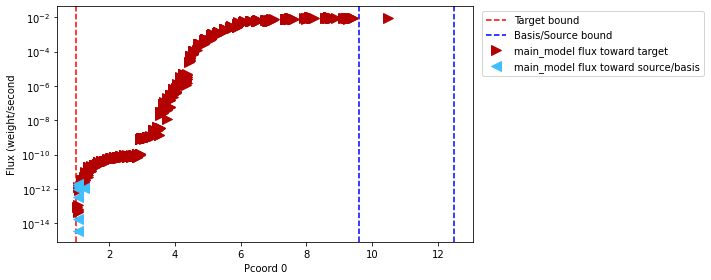

In [4]:
ax = stored_model.plot_flux(suppress_validation=True)

[12/08/21 08:55:00] CRITICAL No cross-validation models have been generated!   ]8;id=1638982500.51397-180557;file:///Users/russojd/Research/molssi_2021/msmWE_cc/msm_we/msm_we/msm_we.py\msm_we.py]8;;\:5721
                             Do this before making plots.

                    WARNING  Committors have not yet been generated for        ]8;id=1638982500.533936-642297;file:///Users/russojd/Research/molssi_2021/msmWE_cc/msm_we/msm_we/msm_we.py\msm_we.py]8;;\:5747
                             main_model, generating now.

                    WARNING  Note that, if steady-state weighted ensemble data ]8;id=1638982500.53617-164127;file:///Users/russojd/Research/molssi_2021/msmWE_cc/msm_we/msm_we/msm_we.py\msm_we.py]8;;\:6684
                             is being analyzed, this is a 'pseudocommittor'                  
                             and not a true committor as a result of being                   
                             constructed from a one-way ensemble.

  0%|          | 0/5.0 [00:00<?, ?it/s]

                    WARNING  Committor-fluxes have not yet been generated for  ]8;id=1638982500.703777-341180;file:///Users/russojd/Research/molssi_2021/msmWE_cc/msm_we/msm_we/msm_we.py\msm_we.py]8;;\:5753
                             main_model, generating now.

Obtaining pseudocommittor-fluxes:   0%|          | 0/918 [00:00<?, ?it/s]

[12/08/21 08:55:52] WARNING  Note that, if steady-state weighted ensemble data ]8;id=1638982552.9579608-973887;file:///Users/russojd/Research/molssi_2021/msmWE_cc/msm_we/msm_we/msm_we.py\msm_we.py]8;;\:6684
                             is being analyzed, this is a 'pseudocommittor'                  
                             and not a true committor as a result of being                   
                             constructed from a one-way ensemble.

NameError: name 'plt' is not defined

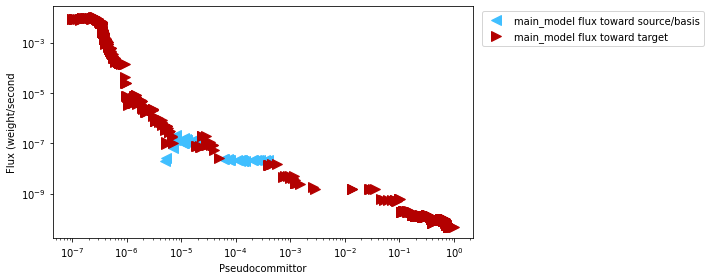

In [5]:
stored_model.plot_flux_committor(suppress_validation=True)
plt.gca().set_xscale('linear')